In [1]:
import numpy as np
import pandas as pd
import math
from msig import Motif, NullModel
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL, MSTL
import matplotlib.pylab as pylab
import matplotlib.dates as mdates

params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 20}
pylab.rcParams.update(params)


In [2]:
#read the data
colnames = ["timestamp","current","power_factor", "water_monitoring_inlet", "water_monitoring_outlet","water_temperature_inlet", "water_temperature_outlet"]
data = pd.read_csv("../data/washingmachine/main_readings.csv", usecols=colnames)
#rename columns
data.columns = ["timestamp","Current (A)","Power Factor", "Water Inlet (ml)", "Water Outlet (ml)","Water Inlet Temperature(°C)", "Water Outlet Temperature(°C)"]
#data_accellerometer = pd.read_csv("../data/washingmachine/main_readings_accelerometer.csv")
#change timestamp from float to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='s')
#drop the microsecond part
data['timestamp'] = data['timestamp'].dt.floor('s')
#remove readings in same second
data = data.drop_duplicates(subset='timestamp', keep='first')
#assume first as 00:00:00 of the day
first_datetime = data['timestamp'].iloc[0]
time_diff = data['timestamp'].apply(lambda x: x - first_datetime)
first_datetime = first_datetime.replace(hour=0, minute=0, second=0)
data['timestamp'] = first_datetime + time_diff
data = data.set_index('timestamp')
data


Current (A)  Power Factor  Water Inlet (ml)  \
timestamp                                                          
2023-07-14 00:00:00        0.064          0.00               0.0   
2023-07-14 00:00:01        0.064          0.00               0.0   
2023-07-14 00:00:02        0.064          0.00               0.0   
2023-07-14 00:00:03        0.065          0.00               0.0   
2023-07-14 00:00:04        0.065          0.00               0.0   
...                          ...           ...               ...   
2023-07-14 03:55:02        0.064          0.03               0.0   
2023-07-14 03:55:03        0.064          0.03               0.0   
2023-07-14 03:55:04        0.064          0.03               0.0   
2023-07-14 03:55:05        0.064          0.03               0.0   
2023-07-14 03:55:06        0.064          0.03               0.0   

                     Water Outlet (ml)  Water Inlet Temperature(°C)  \
timestamp                                                             
2023-07-14 00:00:00                0.0                      17.6250   
2023-07-14 00:00:01                0.0                      17.0625   
2023-07-14 00:00:02                0.0                      17.0000   
2023-07-14 00:00:03                0.0                      17.0625   
2023-07-14 00:00:04                0.0                      17.0625   
...                                ...                          ...   
2023-07-14 03:55:02                0.0                      18.5000   
2023-07-14 03:55:03                0.0                      18.5000   
2023-07-14 03:55:04                0.0                      18.5000   
2023-07-14 03:55:05                0.0                      18.5000   
2023-07-14 03:55:06                0.0                      18.5000   

                     Water Outlet Temperature(°C)  
timestamp                                          
2023-07-14 00:00:00                       18.5000  
2023-07-14 00:00:01                       17.1250  
2023-07-14 00:00:02                       17.1250  
2023-07-14 00:00:03                       17.1250  
2023-07-14 00:00:04                       17.1875  
...                                           ...  
2023-07-14 03:55:02                       20.5000  
2023-07-14 03:55:03                       20.5000  
2023-07-14 03:55:04                       20.5000  
2023-07-14 03:55:05                       20.5000  
2023-07-14 03:55:06                       20.5000  

[14101 rows x 6 columns]

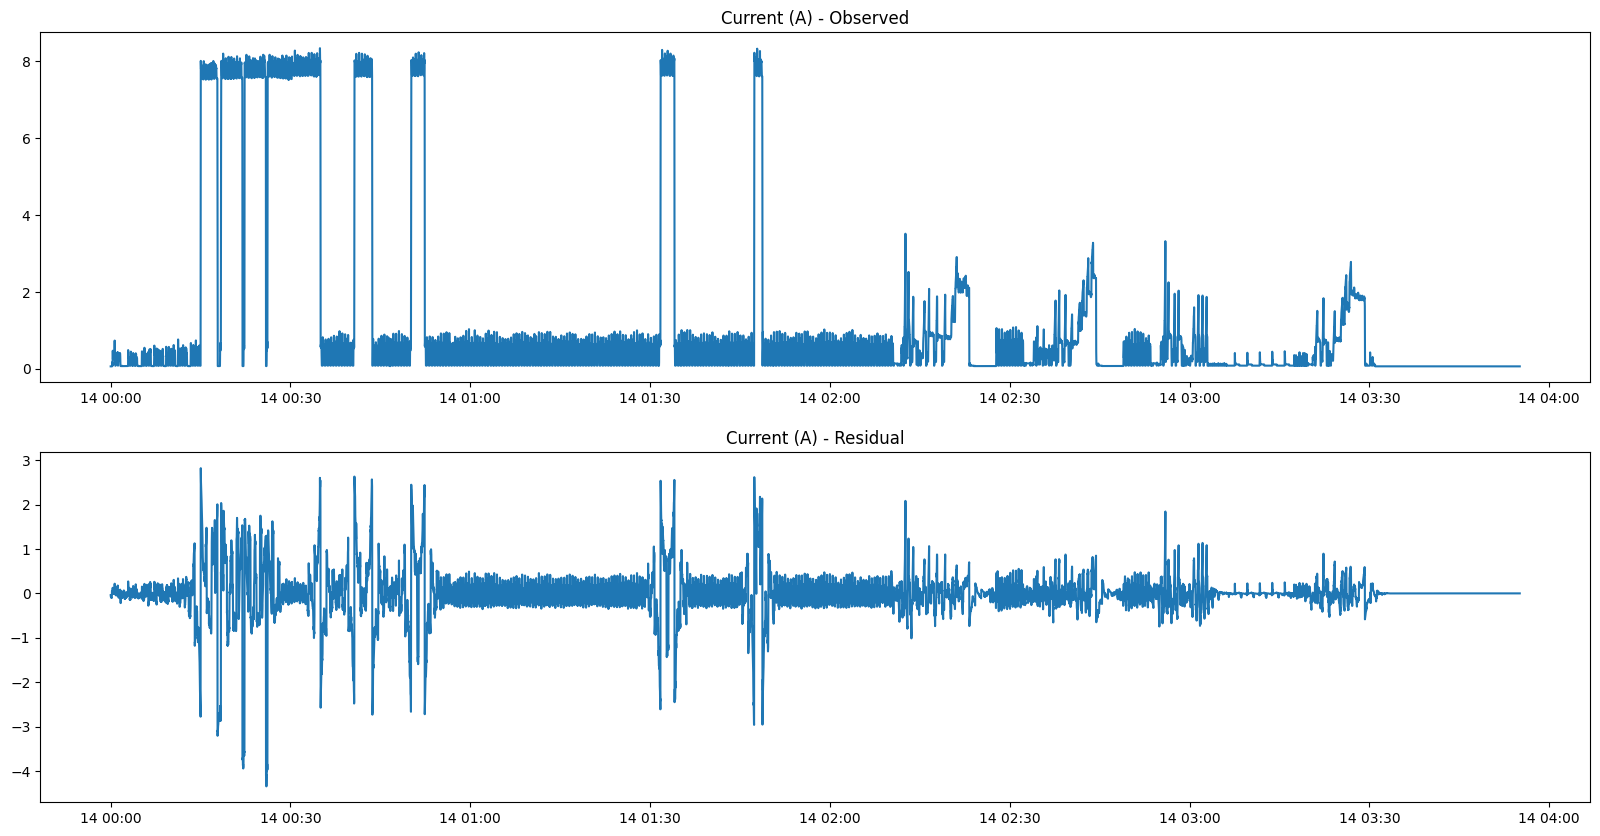

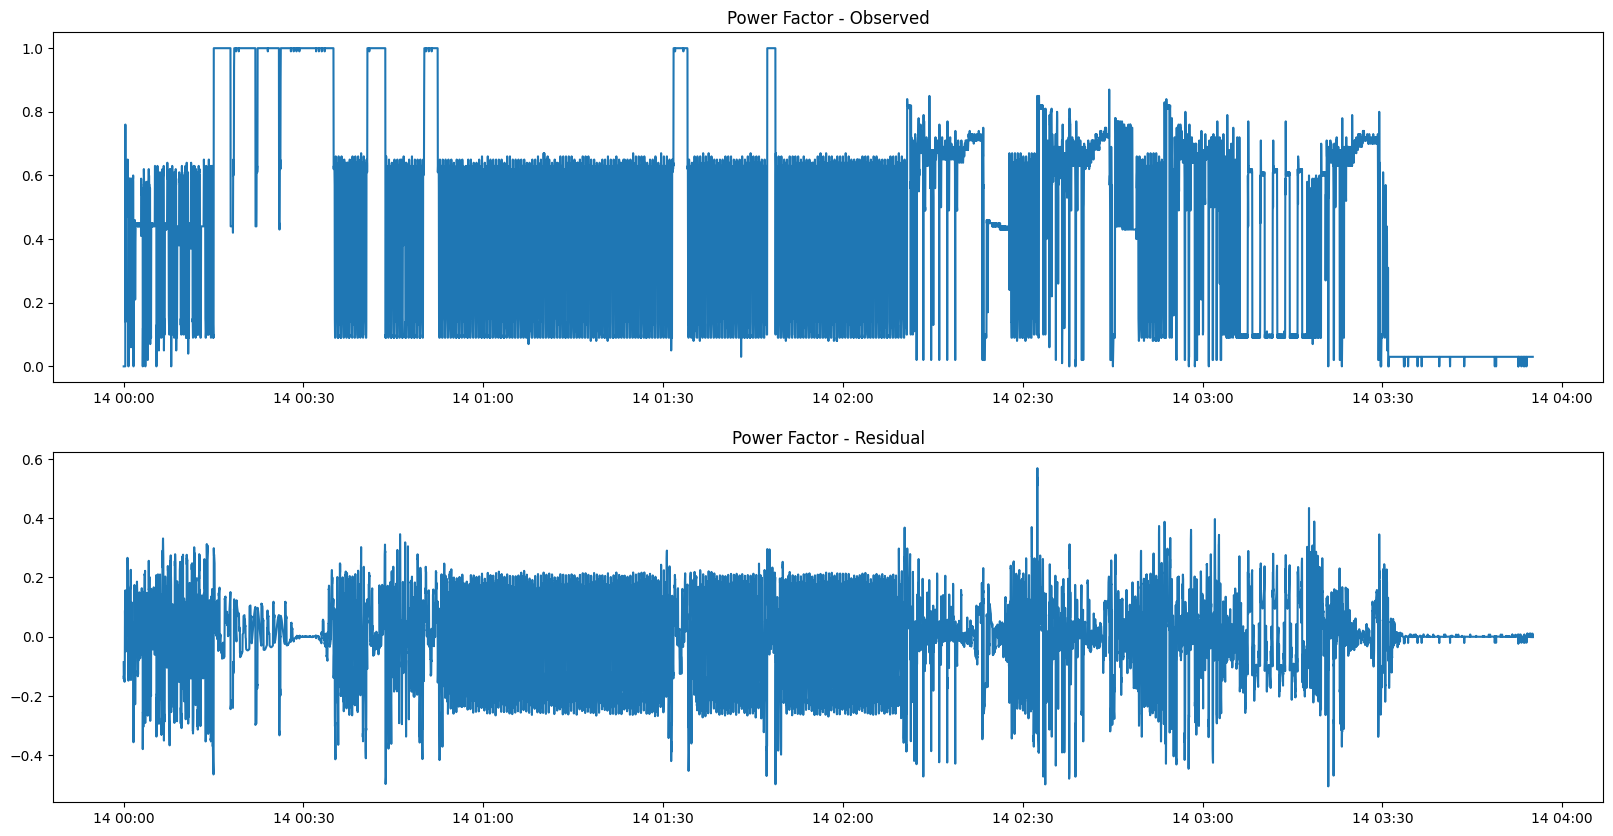

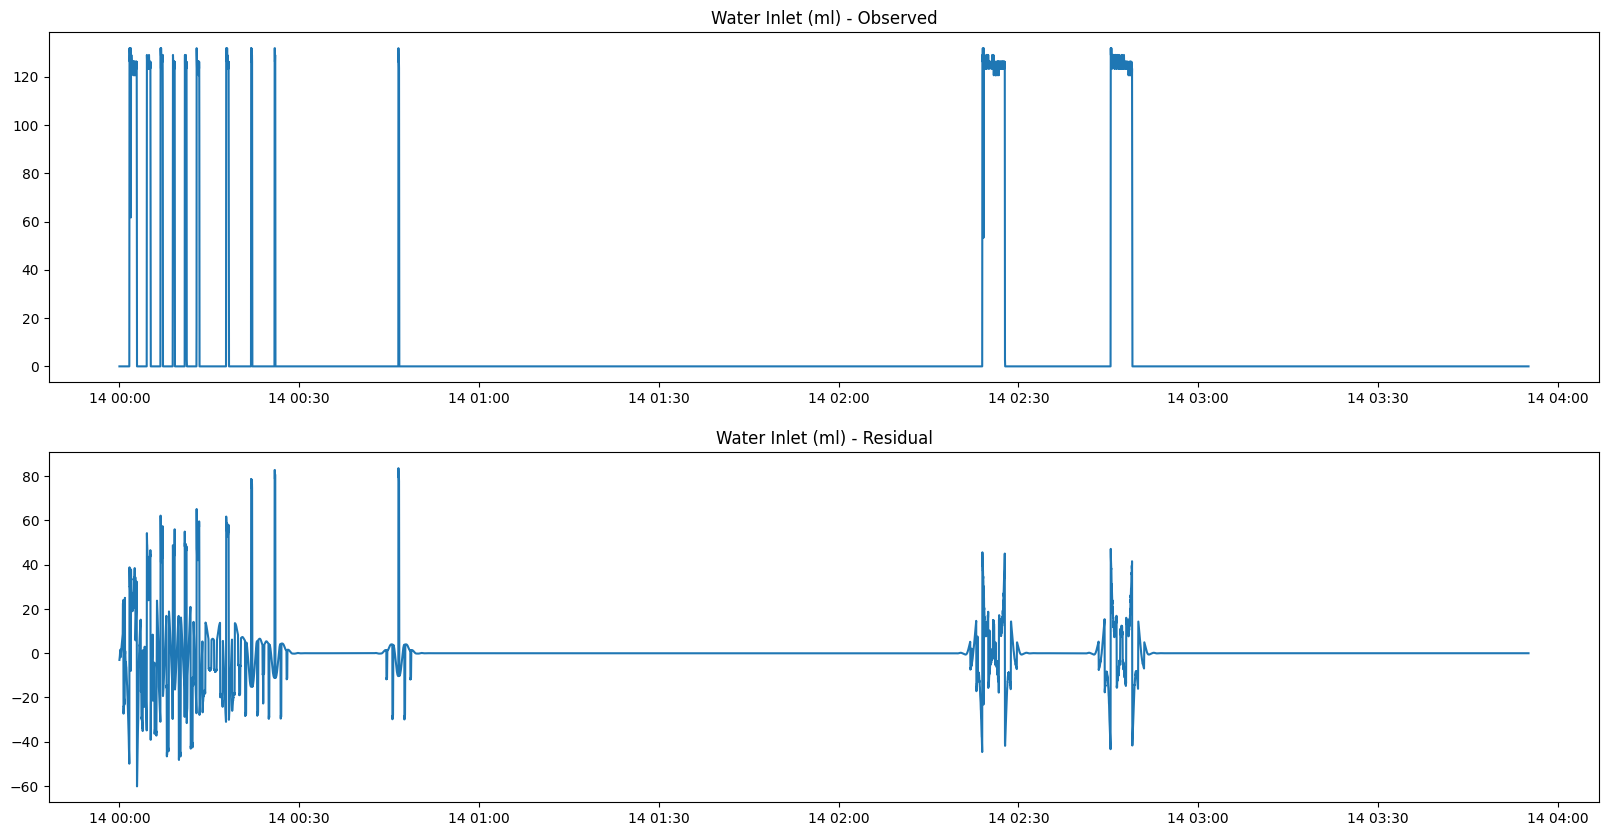

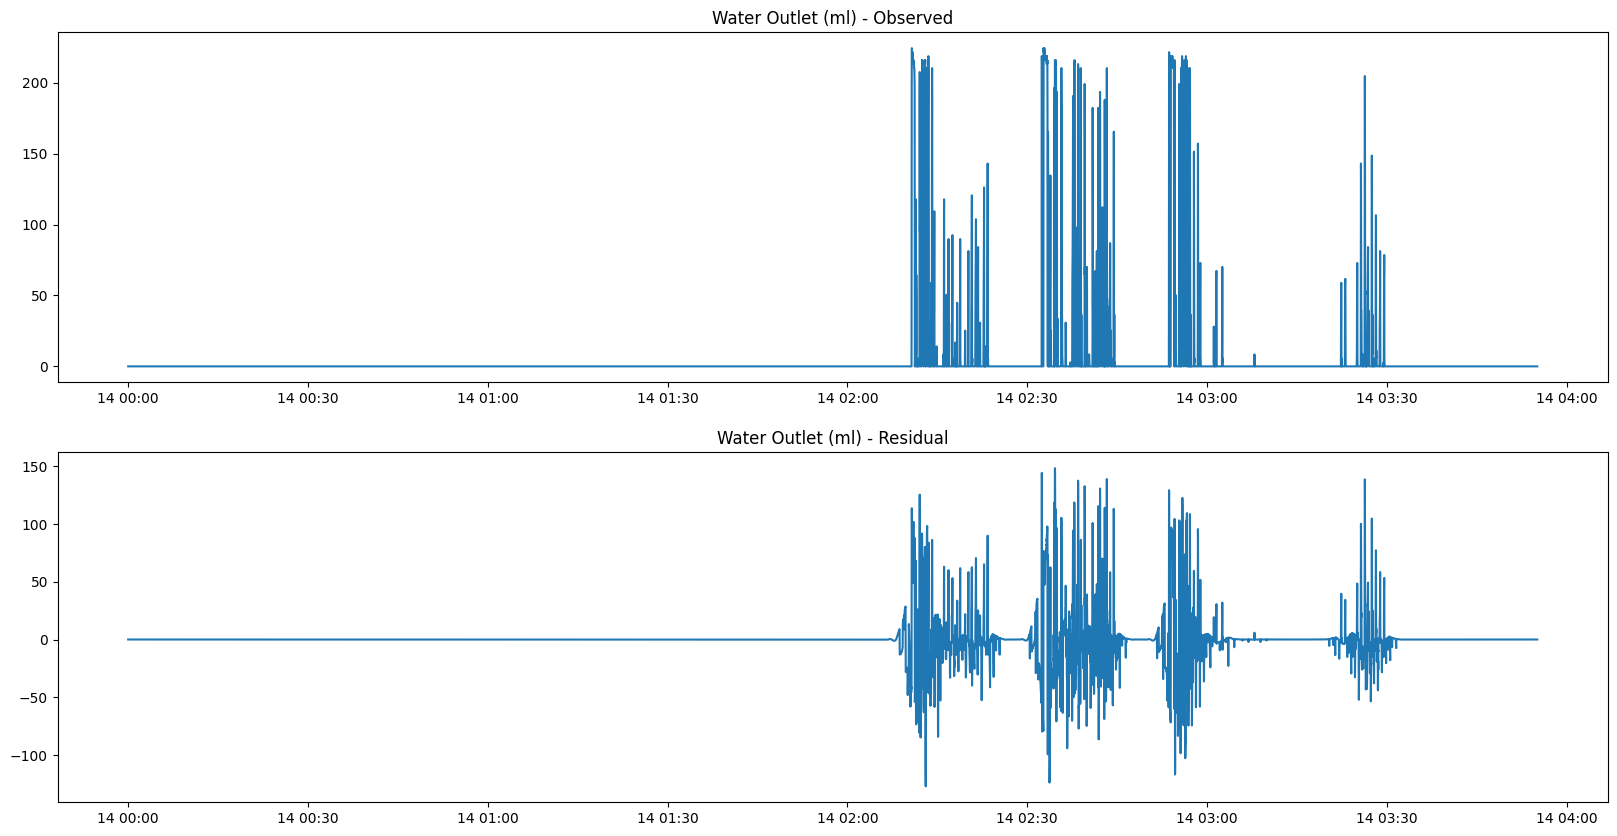

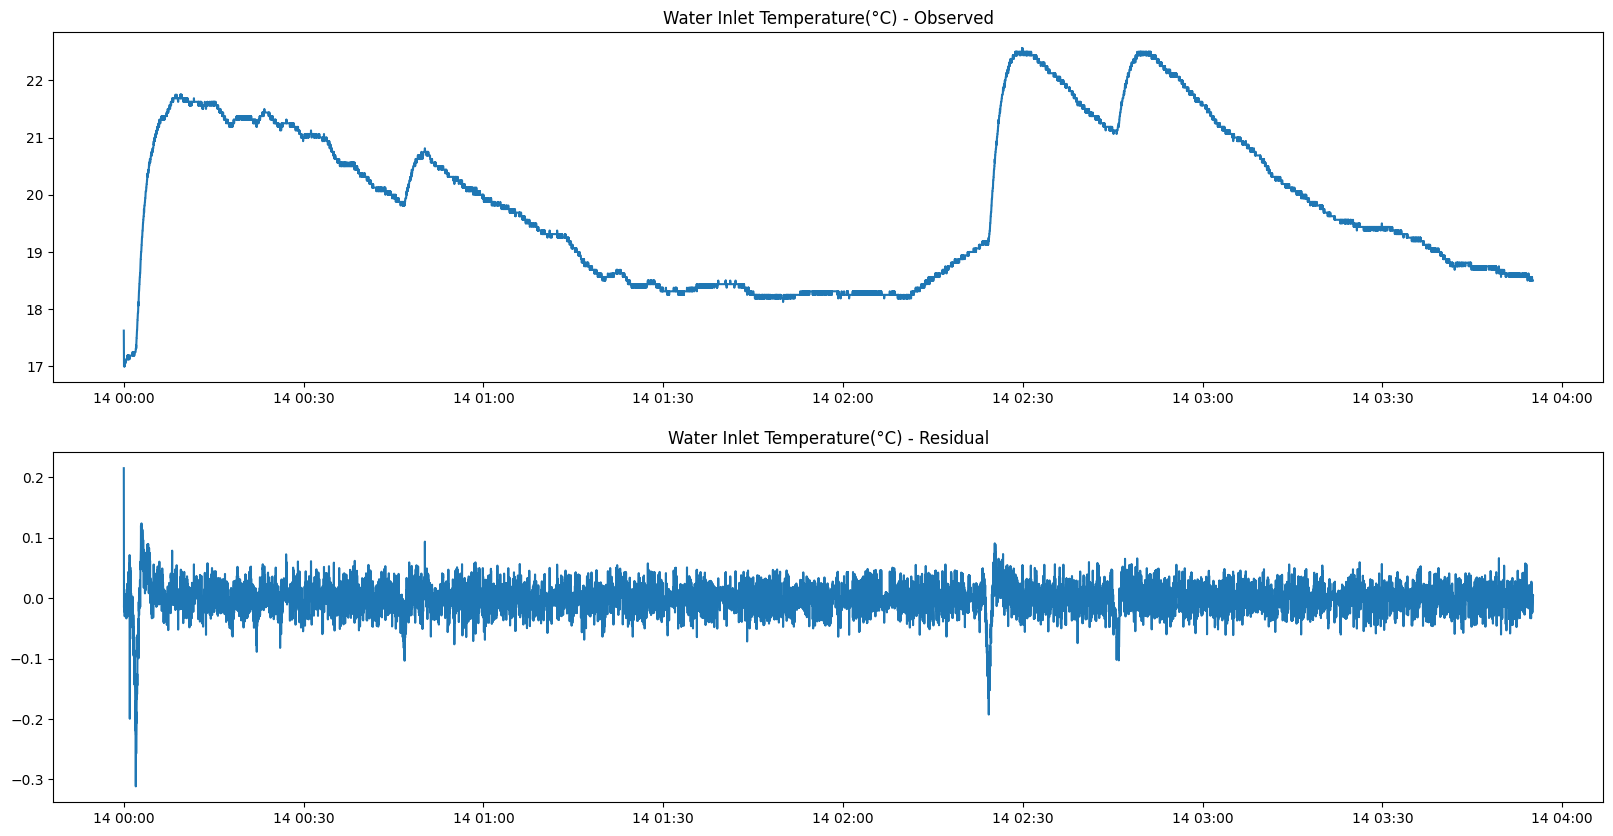

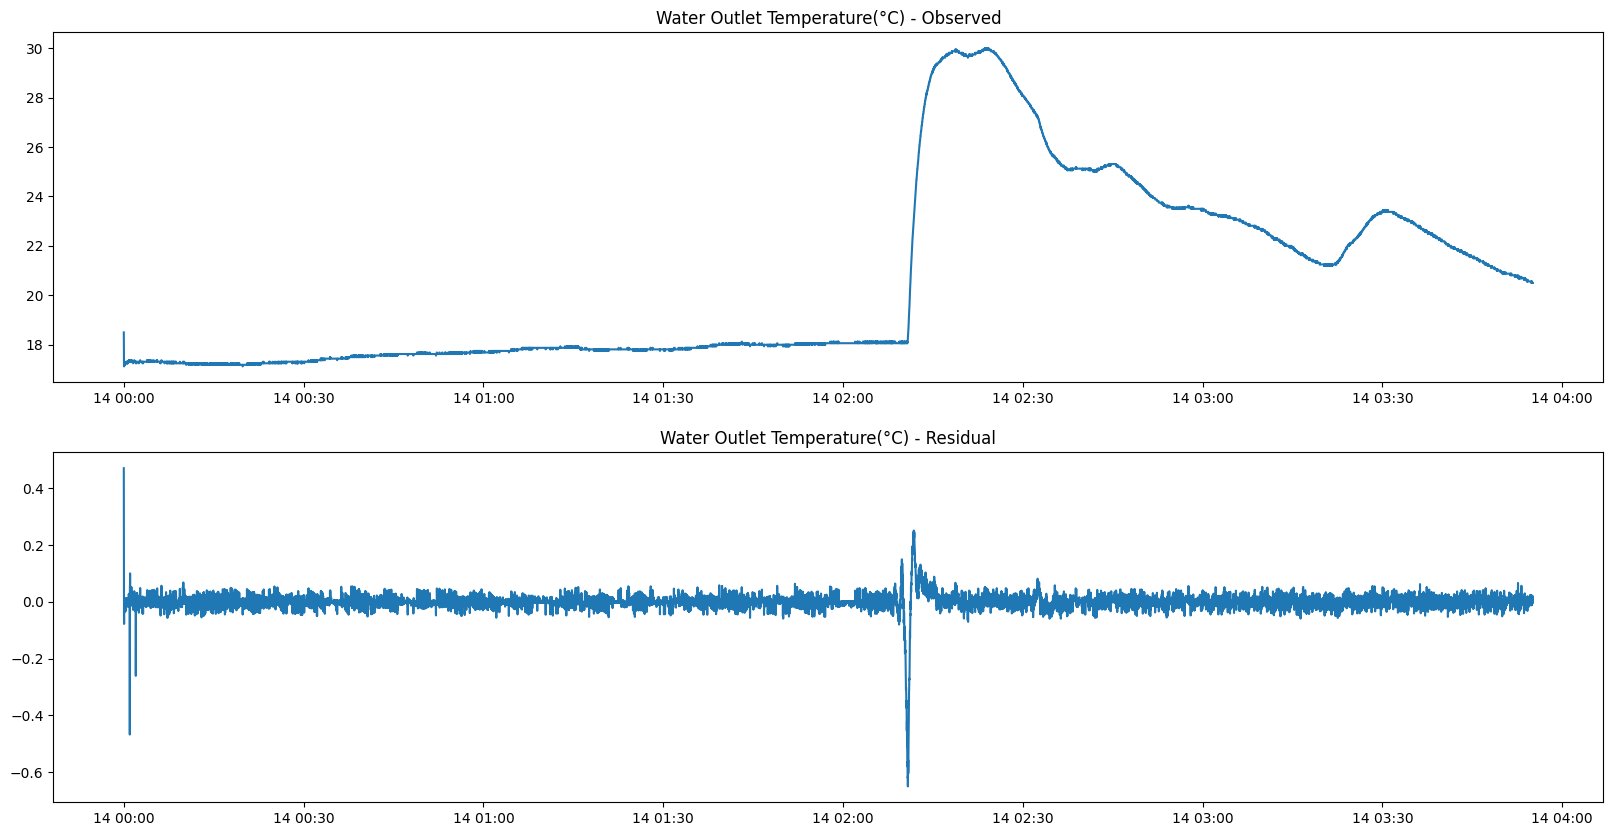

Feature    F_T    F_S    F_R
0                   Current (A)  0.953  0.356  0.046
1                  Power Factor  0.780  0.517  0.178
2              Water Inlet (ml)  0.870  0.404  0.120
3             Water Outlet (ml)  0.615  0.366  0.316
4   Water Inlet Temperature(°C)  1.000  0.281  0.000
5  Water Outlet Temperature(°C)  1.000  0.224  0.000

In [3]:
#resid
stats_table = pd.DataFrame()
resids = {}

#get the data for those features
for data_feature in data.columns:
    time_serie = data[data_feature].asfreq('s', method='ffill')
    res = STL(np.squeeze(time_serie), period=60).fit() #1 minute seasonality
    resids[data_feature] = res.resid

    var_resid = np.var(res.resid)
    var_observed = np.var(res.observed)
    trend_strength = max(0, 1 - (var_resid/np.var(res.trend+res.resid)))
    noise_strength = var_resid/var_observed
    seasonal_strength = max(0, 1 - (var_resid/np.var(res.seasonal + res.resid)))
    
    stats_df = {"Feature": data_feature,
                "F_T": round(trend_strength, 3),
                "F_S": round(seasonal_strength, 3), "F_R": round(noise_strength, 3)}
            
    stats_table = pd.concat([stats_table, pd.DataFrame(stats_df, index=[0])], ignore_index=True)
    #plot the data
    fig, ax = plt.subplots(2,1, figsize=(20, 10))
    ax[0].plot(res.observed)
    ax[0].set_title(data_feature + " - Observed")
    ax[1].plot(res.resid)
    ax[1].set_title(data_feature + " - Residual")
    plt.show()

    
stats_table

In [4]:
#motif discovery
import stumpy
from stumpy import config

config.STUMPY_EXCL_ZONE_DENOM = 2 # r = np.ceil(m/2)
include = None
normalize = True
subsequence_lengths = [60, 300, 600, 1200]

In [5]:
for m in subsequence_lengths:
    for feature in data.columns:
        out = stumpy.stump(resids[feature], m, normalize=normalize)
        np.save('../results/washingmachine/mp/normalized={}_m={}_{}.npy'.format(normalize,m,feature), out, allow_pickle=True)

In [6]:
def multivar_subsequence_complexity(x):
    # complexity for multivariate time series can be calculated as the sum of the complexity of each dimension
    return np.sum(np.sqrt(np.sum(np.square(np.diff(x)), axis=1)))

def table_summary_motifs(motif_indices, motif_distances, motif_subspaces, data, m, normalize, max_allowed_dist):
    mp_stats_table = pd.DataFrame(columns=["ID", "k", "Features", "m", "#Matches", "Indices", "max(dists)", "min(dists)", "med(dists)"])

    motif_index = 0

    n_vars, n_time = data.shape

    if normalize:
        data = (data - np.mean(data, axis=1)[:, np.newaxis]) / np.std(data, axis=1)[:, np.newaxis]
    
    dtypes = [float] * len(data)
    model_empirical = NullModel(data, dtypes, model="empirical")

    for motif_indice, match_indices in enumerate(motif_indices):

        dimensions = motif_subspaces[motif_indice]
            
        #remove filling values of -1 and Nans from motif_indices and match_distances
        match_indices = match_indices[match_indices != -1]
        match_distances = motif_distances[motif_indice]
        match_distances = match_distances[~np.isnan(match_distances)]

        #if is empty, skip
        if len(match_indices) == 0:
            continue
        
        #remove trivial matches  
        non_trivial_matches = []
        for indice in match_indices:
           trivial = False
           for indice_new in non_trivial_matches:
               if abs(indice - indice_new) <= m/2:
                   trivial = True
                   break
           if not trivial:
               non_trivial_matches.append(indice)
        match_indices = non_trivial_matches

        max_possible_matches = int(np.floor((n_time-m)/np.ceil(m/2)+1))

        #get the multidim time serie motif in the dimensions
        multivar_subsequence = data[dimensions][:,match_indices[0]:match_indices[0]+m]

        #minmax normalize subsequence
        epsilon = 1e-10 # to avoid division by zero
        min_values = multivar_subsequence.min(axis=1, keepdims=True)
        max_values = multivar_subsequence.max(axis=1, keepdims=True)
        normalized_multivar_subsequence = (multivar_subsequence - min_values) / (max_values - min_values + epsilon)
        ce_norm_subsequence = multivar_subsequence_complexity(normalized_multivar_subsequence)
        norm_ce_norm_subsequence = ce_norm_subsequence/(np.sqrt(len(multivar_subsequence[0])-1)*len(dimensions))

        max_dist = np.max(match_distances)
        min_dist = np.min(match_distances[1:])
        avg_dist = np.mean(match_distances[1:])
        std_dist = np.std(match_distances[1:])
        med_dist = np.median(match_distances[1:])
        
        #D is distance profile between the motif pattern and Time serie
        if max_allowed_dist is None:
            D = np.empty((n_time-m+1, len(dimensions)))
            for i, dimension in enumerate(dimensions):
                D[:,i] = stumpy.mass(multivar_subsequence[i], data[dimension], normalize=normalize)
            D = np.mean(D, axis=1)
            max_allowed_dist = max(np.nanmax([np.nanmean(D) - 2.0 * np.nanstd(D), np.nanmin(D)]), epsilon)
        
        unified_weights = "0.33,0.33,0.33"
        excl_zone = np.ceil(m/4)
        w1, w2, w3 = map(float, unified_weights.split(","))
        unified = w1*(1-(med_dist/max_allowed_dist)) + w2*(len(match_indices)/max_possible_matches) + w3*norm_ce_norm_subsequence

        #remove timepoints from time series in match all indices + m
        time_series_nomatches = data[dimension].copy()
        #list of indexes to remove
        indexes_to_remove = [i for index in match_indices for i in range(index, index + m)]
        #put zero in the indexes to remove
        time_series_nomatches[indexes_to_remove] = 0

        #calculate variance explained by the motif
        variance_explained = 100 * (1 - (np.var(time_series_nomatches) / np.var(data[dimension])))

        #data features are now the ones in the dimensions
        used_features = [f"{dimension}" for dimension in dimensions]

        #max_delta = max_allowed_dist # (worst case) max_dist = sqrt(max_delta^2) <=> max_delta = max_dist
        max_delta = math.sqrt(max_allowed_dist**2/m) 
        delta_thresholds = [max_delta]*len(data)
        
        #########SIG#########
        motif = Motif(multivar_subsequence, dimensions, delta_thresholds, len(match_indices))
        p = motif.set_pattern_probability(model_empirical, vars_indep=True)
        pvalue = motif.set_significance(max_possible_matches, n_vars, idd_correction=False) 

        stats_df = {"ID": str(motif_index), "k":len(dimensions),
                    "Features":",".join(used_features),
                        "m":m,
                    "#Matches": len(match_indices)-1,
                        "Indices":match_indices,
                        "max(dists)": np.around(max_dist,3), "min(dists)": np.around(min_dist,3),
                        "med(dists)": np.around(med_dist,3),  "CE": np.around(norm_ce_norm_subsequence,3), "Score Unified": np.around(unified,3),
                        "Explained Var(%)": np.around(variance_explained,2),
                        "P": p, "p-value": pvalue}
    
        mp_stats_table = pd.DataFrame.from_records([stats_df]) if mp_stats_table.empty else pd.concat(
            [mp_stats_table, pd.DataFrame.from_records([stats_df])], ignore_index=True)
        
        motif_index += 1
    return mp_stats_table

In [7]:
k = None
min_neighbors = 1
cutoff = np.inf
max_matches = 99999
max_distance = None
max_motifs = 99999
mp_stats_table = pd.DataFrame()
for m in subsequence_lengths:
    for feature in data.columns:
        X = np.squeeze(resids[feature].values)
        mp = np.load('../results/washingmachine/mp/normalized=True_m={}_{}.npy'.format(m,feature), allow_pickle=True)
        motif_distances, motif_indices = stumpy.motifs(X, mp[:, 0], max_distance=max_distance,max_matches=max_matches,
                                                                            cutoff=cutoff, min_neighbors=min_neighbors, max_motifs=max_motifs, normalize=normalize)
        if len(motif_indices[0]) == 0:
            continue
        print("m:{}, #Motifs:{}".format(m, len(motif_indices)))
        # to work with table_summary_motifs which expects multidimensional motifs
        motif_subspaces = [np.array([0])]*len(motif_indices)
        X = np.array([X])
        table = table_summary_motifs(motif_indices, motif_distances, motif_subspaces, X, m, normalize, max_distance)
        print("Sig ", np.sum(table["p-value"] < 0.01))
        #hochberg procedure
        p_values = table["p-value"].to_numpy()
        critical_value =  NullModel.hochberg_critical_value(p_values, 0.05)
        sig = table["p-value"] < critical_value if critical_value != 0 else table["p-value"] <= critical_value
        table["Sig_Hochber"] = sig

        print("Sig after Hochberg: {}, critical value: {}".format(np.sum(sig), critical_value))
        mp_stats_table = table if mp_stats_table.empty else pd.concat([mp_stats_table, table], ignore_index=True)

        mp_stats_table.to_csv('../results/washingmachine/table_motifs_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}.csv'.format(min_neighbors, max_distance, cutoff, max_matches, max_motifs), index=False)

m:60, #Motifs:11
Sig  4
Sig after Hochberg: 3, critical value: 3.834777376682116e-09
m:60, #Motifs:12
Sig  12
Sig after Hochberg: 11, critical value: 3.2623508146905456e-38
m:60, #Motifs:22
Sig  4
Sig after Hochberg: 4, critical value: 0.0
m:60, #Motifs:51
Sig  39
Sig after Hochberg: 29, critical value: 0.0005394456874582812
m:60, #Motifs:7
Sig  7
Sig after Hochberg: 7, critical value: 0.0
m:60, #Motifs:9
Sig  9
Sig after Hochberg: 8, critical value: 3.281620314313471e-165
m:300, #Motifs:6
Sig  6
Sig after Hochberg: 5, critical value: 4.487094766026123e-14
m:300, #Motifs:6
Sig  6
Sig after Hochberg: 6, critical value: 0.0
m:300, #Motifs:4
Sig  2
Sig after Hochberg: 2, critical value: 0.0
m:300, #Motifs:11
Sig  8
Sig after Hochberg: 4, critical value: 2.1404457825792645e-05
m:300, #Motifs:5
Sig  5
Sig after Hochberg: 5, critical value: 0.0
m:300, #Motifs:6
Sig  6
Sig after Hochberg: 6, critical value: 0.0
m:600, #Motifs:6
Sig  6
Sig after Hochberg: 5, critical value: 1.3526112831501163e

In [8]:
#create a new table for each motif length with statistics of the motifs (number of motifs found,
# number of significant motifs, average number of matches +- std, average of features +- std, 
#average probability +- std, average pvalue +- std)

for feature in data.columns:
    mp_stats_table = pd.read_csv('../results/washingmachine/table_motifs_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}.csv'.format(min_neighbors, max_distance, cutoff, max_matches, max_motifs))
    motif_lengths = mp_stats_table["m"].unique()
    motif_stats_table = pd.DataFrame(columns=["m", "#motifs" , "avg_n_matches", "avg_n_features",  "avg_probability",  "avg_pvalue", "#sig_motifs(<0.01)", "significant", "#sig_hochberg"])
    for m in subsequence_lengths:
        table = mp_stats_table[mp_stats_table["m"] == m]
        n_motifs = table.shape[0]
        n_sig_motifs_001 = table[table["p-value"] < 0.01].shape[0]
        n_sig_motifs_hochberg = table[table["Sig_Hochber"]].shape[0]
        avg_n_matches = round(table["#Matches"].mean(),2), round(table["#Matches"].std(),3)
        avg_n_features = round(table["k"].mean(),2), round(table["k"].std(),3)
        avg_probability = table["P"].mean(), table["P"].std()    
        avg_pvalue = table["p-value"].mean(), table["p-value"].std()

        stats_df = {"m": m, "#motifs": n_motifs, "#sig_motifs(<0.01)": n_sig_motifs_001, "significant":(n_sig_motifs_001*100)/n_motifs,"#sig_hochberg": n_sig_motifs_hochberg,
                    "avg_n_matches": avg_n_matches, "avg_n_features": avg_n_features, "avg_probability": avg_probability, "avg_pvalue": avg_pvalue}
        
        motif_stats_table = pd.DataFrame.from_records([stats_df]) if motif_stats_table.empty else pd.concat([motif_stats_table, pd.DataFrame.from_records([stats_df])], ignore_index=True)
    print(motif_stats_table)


      m  #motifs  #sig_motifs(<0.01)  significant  #sig_hochberg  \
0    60      112                  75    66.964286             62   
1   300       38                  33    86.842105             28   
2   600       50                  49    98.000000             33   
3  1200       33                  32    96.969697             23   

     avg_n_matches avg_n_features  \
0  (52.51, 55.219)     (1.0, 0.0)   
1  (22.61, 18.504)     (1.0, 0.0)   
2   (11.84, 9.184)     (1.0, 0.0)   
3    (6.36, 4.241)     (1.0, 0.0)   

                                avg_probability  \
0     (0.1707796782957165, 0.25361663705319015)   
1     (0.0424373182130424, 0.11599719304775469)   
2   (0.008701645486482884, 0.04861570239826511)   
3  (0.007858137366700851, 0.044960760081518836)   

                                     avg_pvalue  
0      (0.3168355926160079, 0.4625629885113057)  
1     (0.09975631321697301, 0.2817977114610824)  
2  (0.002563679018552688, 0.017565322188206896)  
3  (0.00269671114

In [9]:
#get top 3 most significant for each motif length
for m in subsequence_lengths:
    for data_feature in data.columns:
        mp_stats_table = pd.read_csv('../results/washingmachine/table_motifs_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}.csv'.format(min_neighbors, max_distance, cutoff, max_matches, max_motifs))
        mp_stats_table = mp_stats_table[mp_stats_table["m"] == m]
        mp_stats_table.sort_values(by=["p-value"], inplace=True)
        top_3_motifs = mp_stats_table.head(3)
        print(top_3_motifs.to_latex(index=False, columns=["ID", "k", "Features", "#Matches", "max(dists)", "min(dists)", "med(dists)", "P", "p-value"]))
        

\begin{tabular}{rrrrrrrrr}
\toprule
ID & k & Features & #Matches & max(dists) & min(dists) & med(dists) & P & p-value \\
\midrule
8 & 1 & 0 & 162 & 9.427000 & 7.627000 & 9.068000 & 0.000010 & 0.000000 \\
7 & 1 & 0 & 186 & 9.536000 & 7.336000 & 9.193000 & 0.000000 & 0.000000 \\
0 & 1 & 0 & 26 & 7.910000 & 2.452000 & 7.202000 & 0.000000 & 0.000000 \\
\bottomrule
\end{tabular}

\begin{tabular}{rrrrrrrrr}
\toprule
ID & k & Features & #Matches & max(dists) & min(dists) & med(dists) & P & p-value \\
\midrule
8 & 1 & 0 & 162 & 9.427000 & 7.627000 & 9.068000 & 0.000010 & 0.000000 \\
7 & 1 & 0 & 186 & 9.536000 & 7.336000 & 9.193000 & 0.000000 & 0.000000 \\
0 & 1 & 0 & 26 & 7.910000 & 2.452000 & 7.202000 & 0.000000 & 0.000000 \\
\bottomrule
\end{tabular}

\begin{tabular}{rrrrrrrrr}
\toprule
ID & k & Features & #Matches & max(dists) & min(dists) & med(dists) & P & p-value \\
\midrule
8 & 1 & 0 & 162 & 9.427000 & 7.627000 & 9.068000 & 0.000010 & 0.000000 \\
7 & 1 & 0 & 186 & 9.536000 & 7.336000 & 

In [10]:
def plot_motif(ts_list, features,  m, motif_indexes, motif_name):

    fig, axes = plt.subplots(ncols=2, nrows=len(ts_list), figsize=(10, 2*len(ts_list)), squeeze=False)
    for i in range(0,len(ts_list)):
        ts = ts_list[i]
        #plot light grey
        axes[i,1].plot(ts, color='black', linewidth=0.5, alpha=0.5)

        colors = plt.cm.tab20(np.linspace(0, 1, len(motif_indexes)))
        axes[i,0].set_prop_cycle('color', colors)
        axes[i,1].set_prop_cycle('color', colors)

        for index in motif_indexes:
            subsequence_match = ts.iloc[index:index+m]
            #original motif in the next plot with the same color
            axes[i,0].plot(subsequence_match.values) 
            # highlight the motif in the original time serie
            axes[i,1].plot(subsequence_match, linewidth=2)
        
        plt.setp(axes[i,0].xaxis.get_majorticklabels(), rotation=90)
        #remove x labels and ticks except from last plot
        if i != len(ts_list)-1:
            axes[i,0].axes.get_xaxis().set_visible(False)
            axes[i,1].axes.get_xaxis().set_visible(False)

        plt.setp(axes[i,0].xaxis.get_majorticklabels(), rotation=90)

        #format the x axis to show the time and rotate for better reading
        axes[i,1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        plt.setp(axes[i,1].xaxis.get_majorticklabels(), rotation=45)
        axes[i,0].set_ylabel(features[i], rotation=90, size='large')


    #title of the fig
    axes[0,0].set_title("Raw Subsequences")
    axes[0,1].set_title("Motif in TS")
    plt.tight_layout()
    plt.savefig('../results/washingmachine/m='+str(m)+'_motif_'+str(motif_name)+".pdf",bbox_inches='tight')
  
    return None

Motif length:  60
{'ID': 8, 'k': 1, 'Features': 0, 'm': 60, '#Matches': 162, 'Indices': '[10886, 12840, 4930, 13020, 10033, 188, 4155, 11761, 10275, 2483, 9853, 13968, 8245, 7555, 3751, 5228, 10591, 12477, 569, 12565, 8771, 2175, 3975, 10782, 9775, 7278, 5754, 3296, 865, 11403, 10127, 473, 4326, 9100, 12191, 5106, 2707, 11838, 4493, 5850, 12441, 9457, 9732, 8555, 6807, 8680, 11161, 1464, 1858, 283, 2835, 12735, 10706, 332, 8996, 3585, 1244, 8148, 5945, 12372, 8281, 8964, 5719, 6730, 8891, 8468, 7677, 12119, 5159, 10943, 4786, 5463, 7207, 12295, 10974, 5008, 4398, 7381, 11031, 11667, 2404, 12656, 10444, 7084, 9191, 13581, 6123, 6695, 6053, 5507, 7859, 2976, 1051, 11877, 9284, 8418, 1610, 2633, 5592, 7745, 10515, 4261, 9584, 1752, 3075, 11252, 5400, 3122, 3857, 6251, 4089, 3454, 5299, 13099, 13473, 7027, 6990, 1336, 13823, 13173, 13366, 11502, 1189, 13262, 5646, 3255, 3026, 11357, 721, 1305, 6467, 4657, 430, 6296, 10363, 1708, 1409, 3669, 7162, 2051, 3939, 12154, 6634, 537, 4191, 1134, 1

{'ID': 7, 'k': 1, 'Features': 0, 'm': 60, '#Matches': 186, 'Indices': '[2934, 3159, 11395, 2146, 9534, 1379, 1433, 7293, 11355, 13464, 1098, 3503, 9703, 3822, 4373, 3105, 7548, 1879, 5939, 8975, 9757, 1629, 2042, 11205, 6717, 2557, 1807, 13161, 3063, 10918, 6109, 11727, 2769, 3559, 560, 6362, 8376, 3226, 13693, 13064, 5894, 4111, 7153, 4464, 4630, 11653, 4810, 9424, 11906, 13915, 2991, 13520, 7333, 4922, 163, 6010, 455, 5649, 258, 8198, 2723, 8541, 2832, 3709, 12740, 7002, 8145, 4149, 10602, 5485, 8324, 4020, 5145, 3770, 6784, 9371, 10148, 9607, 8267, 1563, 3322, 8772, 10547, 836, 3192, 9854, 10722, 11980, 9327, 2682, 949, 7367, 980, 6287, 6436, 12281, 3446, 731, 7106, 5590, 4989, 2462, 5436, 6536, 12039, 8644, 10480, 12786, 2391, 6896, 11452, 12176, 5388, 10778, 5244, 1959, 9926, 912, 397, 1258, 10096, 4575, 11132, 9075, 12365, 13817, 1020, 13006, 5769, 12704, 10365, 12144, 9472, 3615, 10440, 12926, 12100, 10844, 2875, 1483, 6069, 2294, 13273, 4747, 5814, 2636, 10217, 7400, 13960, 469

/tmp/ipykernel_24936/3111129009.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(ncols=2, nrows=len(ts_list), figsize=(10, 2*len(ts_list)), squeeze=False)


Motif length:  1200
{'ID': 8, 'k': 1, 'Features': 0, 'm': 1200, '#Matches': 8, 'Indices': '[8708, 3864, 4466, 5085, 5688, 6289, 11219, 11820, 12421]', 'max(dists)': 0.0, 'min(dists)': 0.0, 'med(dists)': 0.0, 'CE': 0.029, 'Score Unified': 0.475, 'Explained Var(%)': 5.78, 'P': 2.2407254087168892e-70, 'p-value': 0.0, 'Sig_Hochber': True}
{'ID': 2, 'k': 1, 'Features': 0, 'm': 1200, '#Matches': 15, 'Indices': '[7146, 2777, 3569, 4358, 12314, 8629, 11216, 6072, 0, 710, 9334, 1536, 10588, 5364, 2143, 8027]', 'max(dists)': 46.673, 'min(dists)': 44.411, 'med(dists)': 46.237, 'CE': 0.22, 'Score Unified': 0.301, 'Explained Var(%)': 96.92, 'P': 5.698923553799089e-187, 'p-value': 0.0, 'Sig_Hochber': True}
{'ID': 1, 'k': 1, 'Features': 0, 'm': 1200, '#Matches': 4, 'Indices': '[7778, 9063, 1925, 448, 12439]', 'max(dists)': 44.482, 'min(dists)': 37.101, 'med(dists)': 41.212, 'CE': 0.092, 'Score Unified': 0.131, 'Explained Var(%)': 42.56, 'P': 1.5721475155565387e-232, 'p-value': 0.0, 'Sig_Hochber': Tru

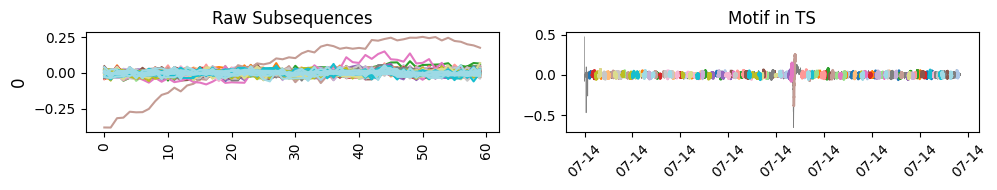

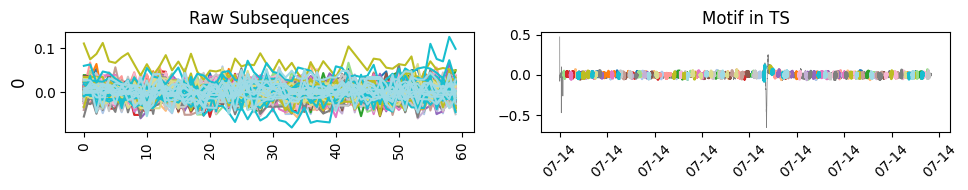

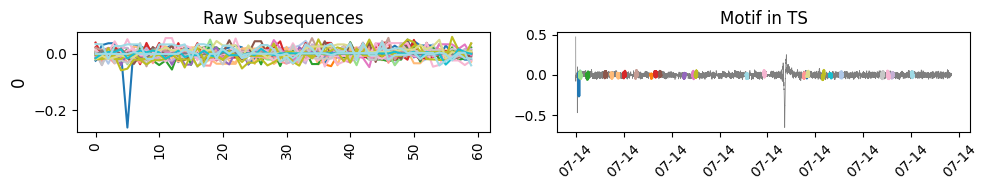

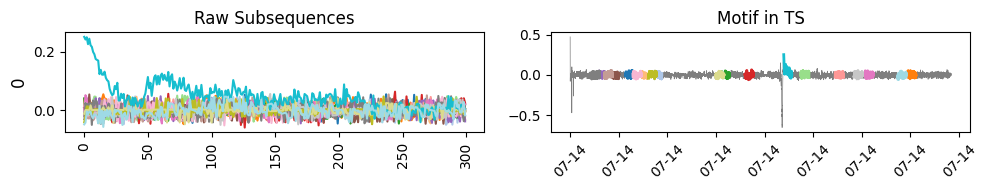

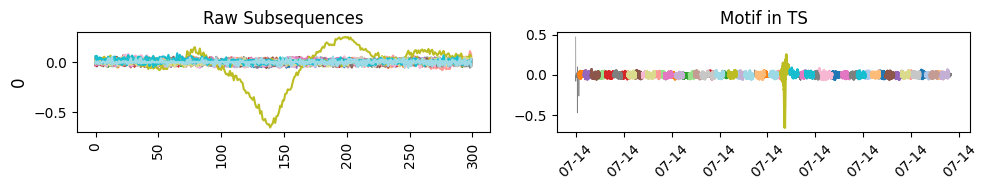

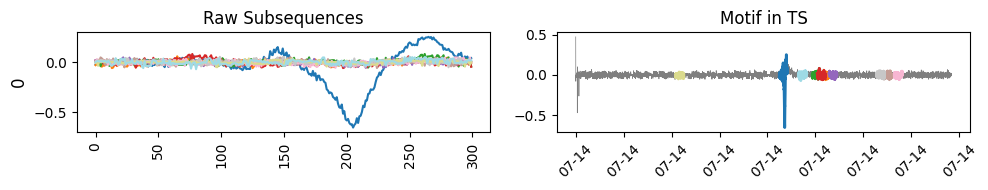

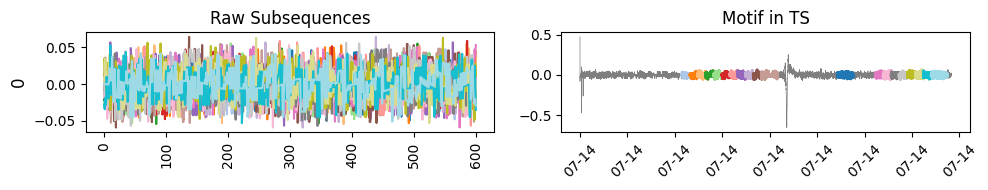

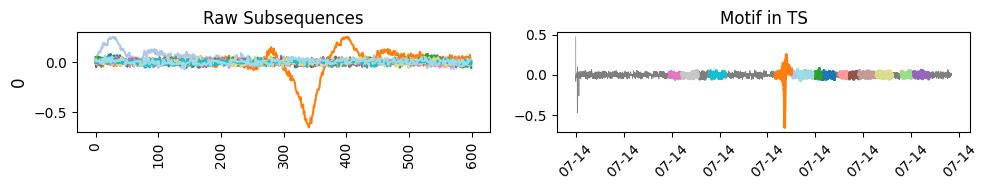

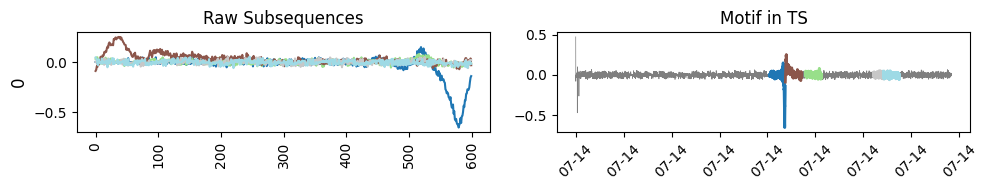

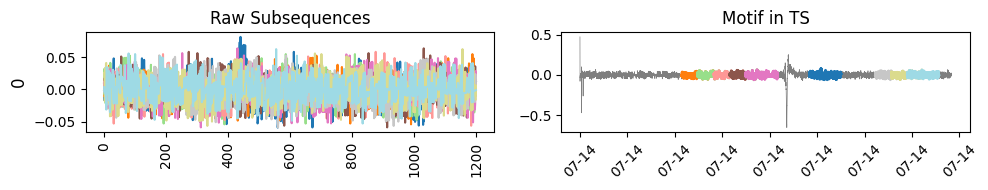

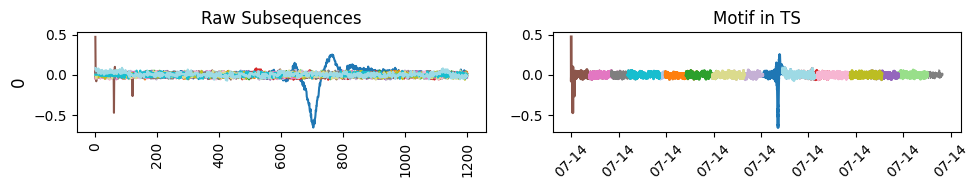

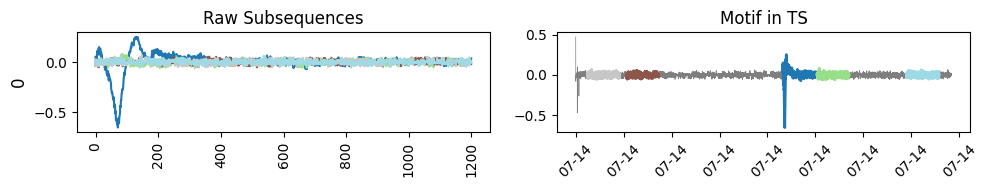

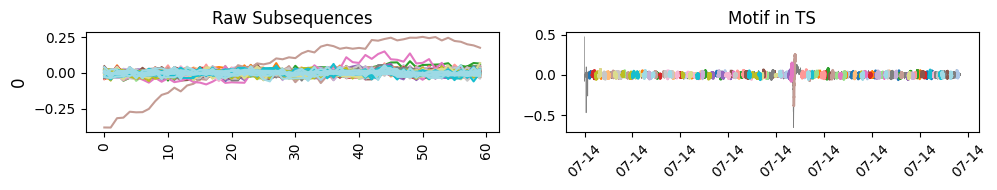

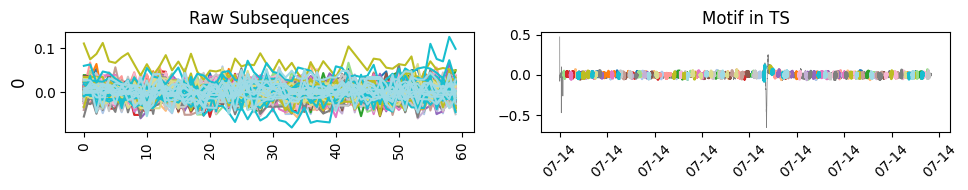

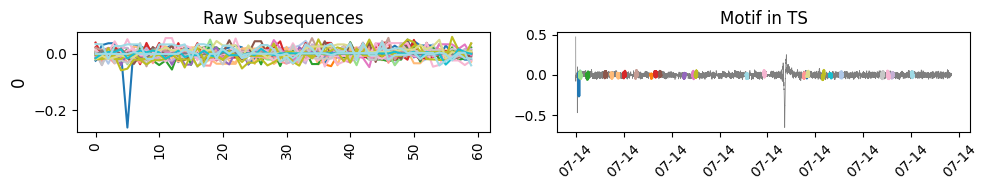

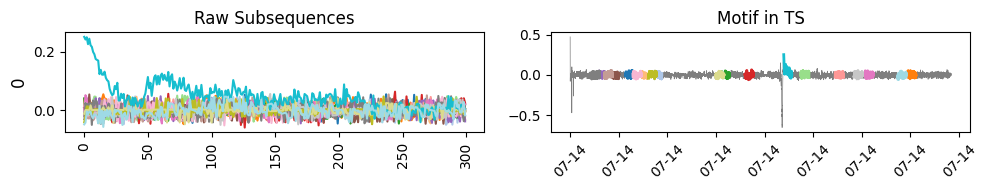

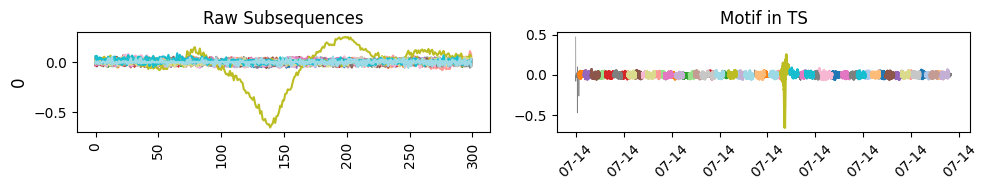

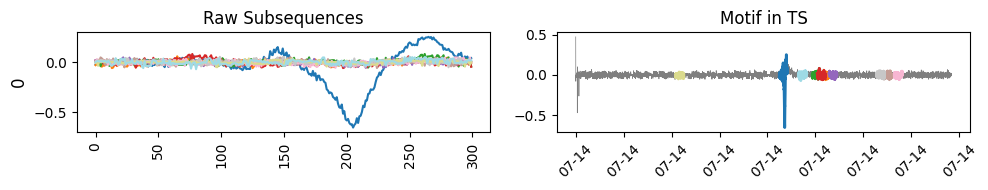

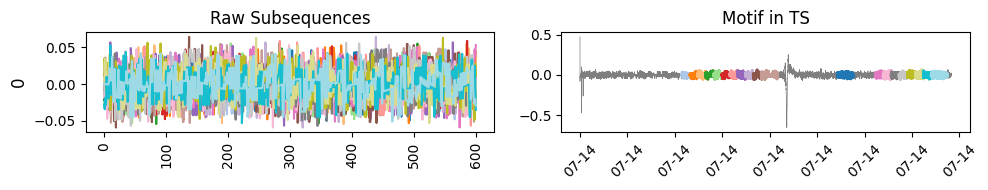

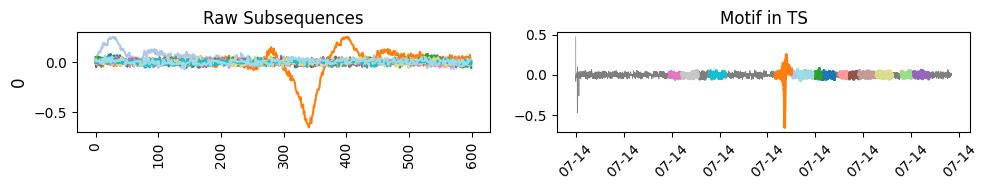

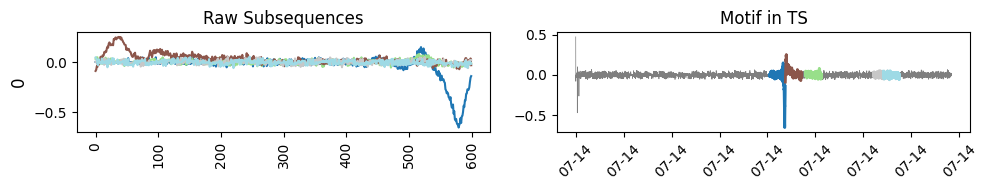

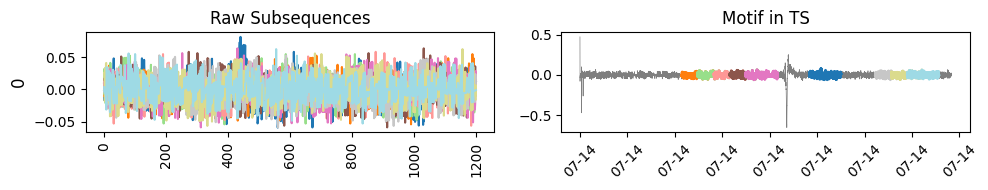

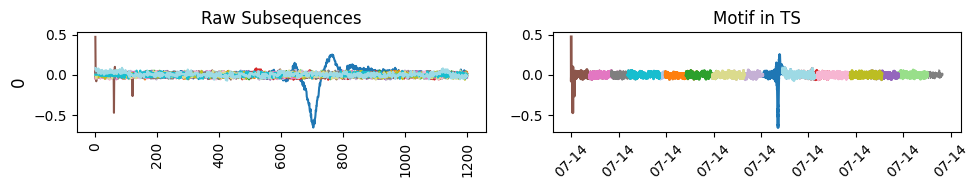

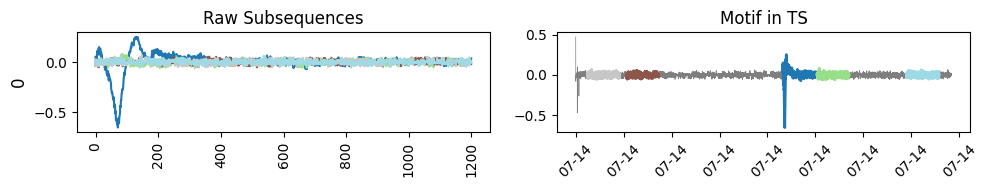

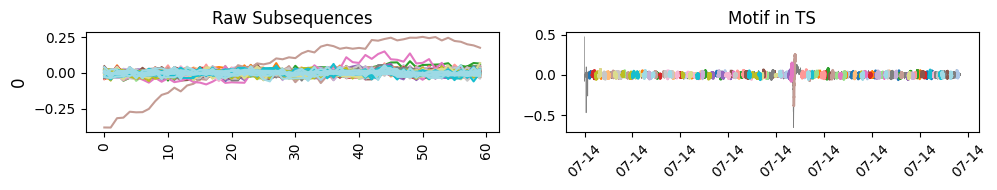

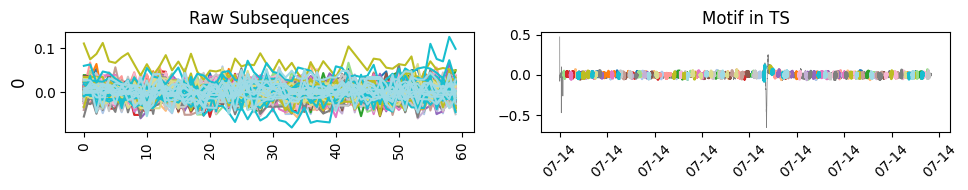

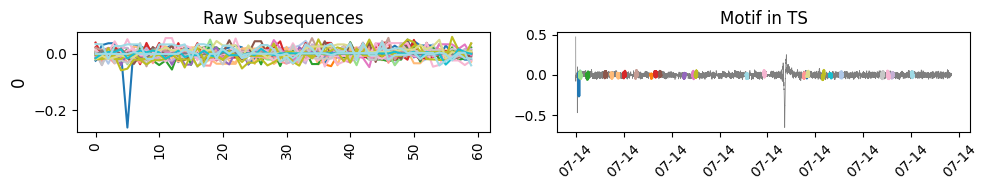

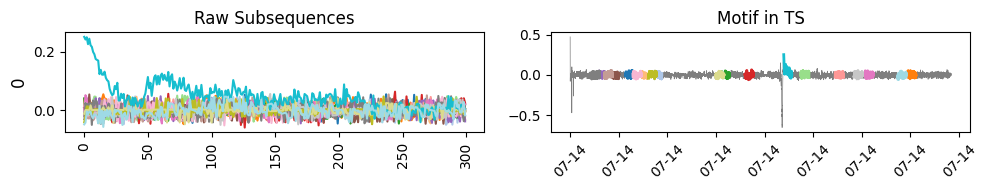

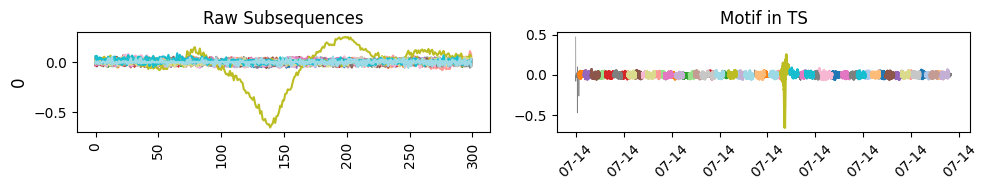

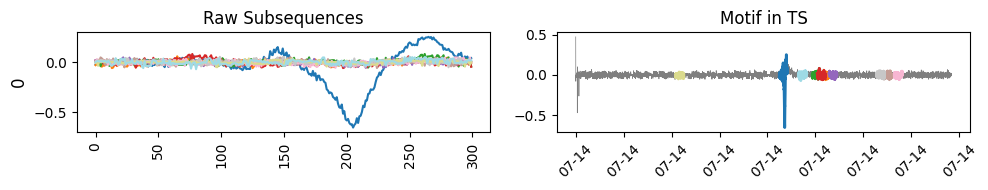

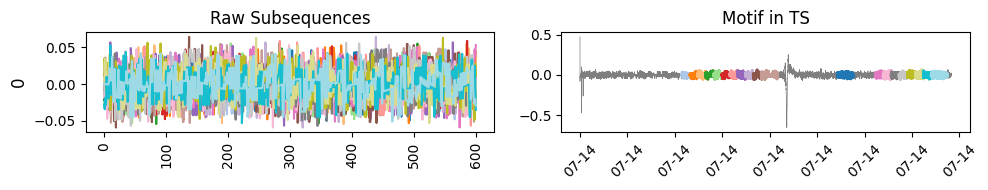

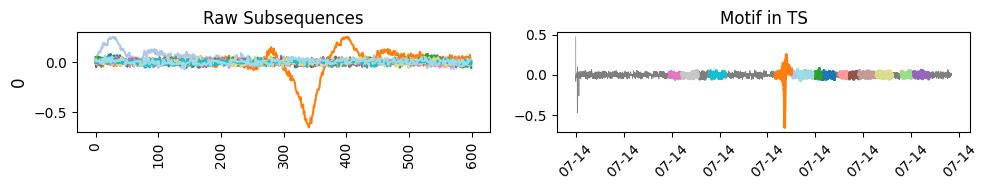

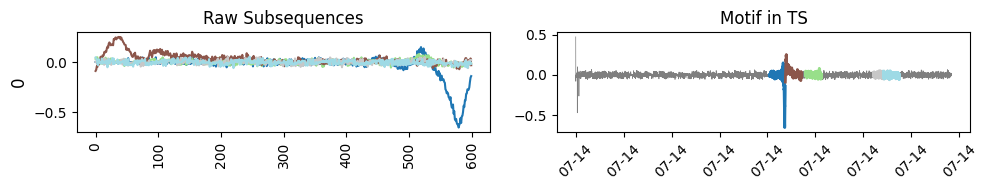

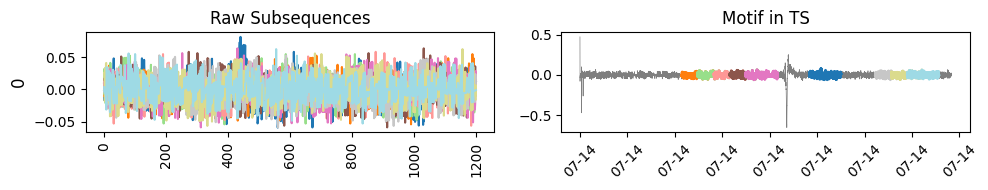

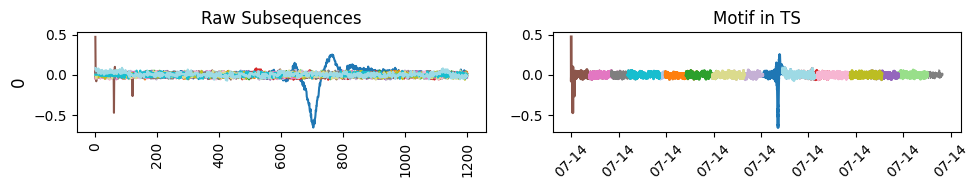

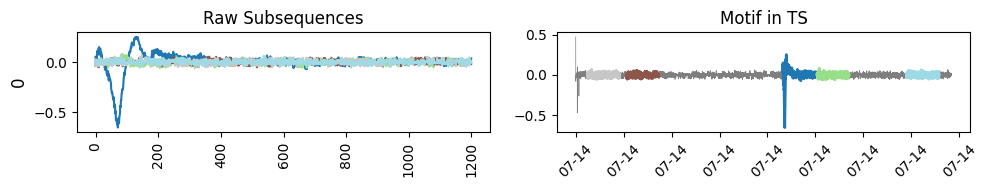

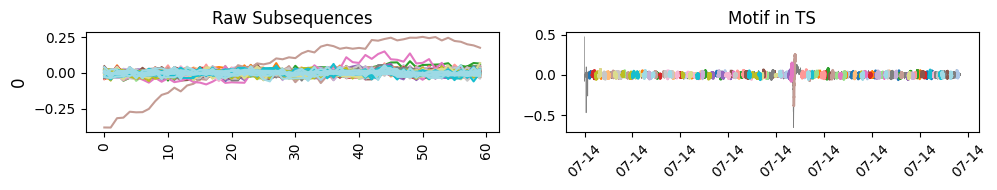

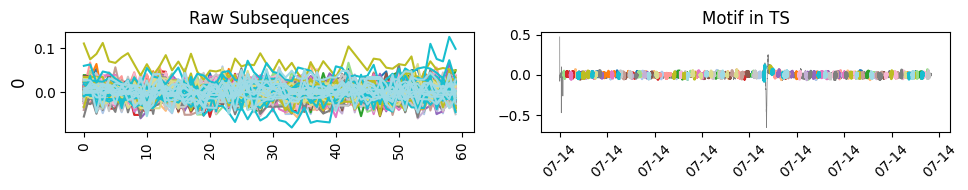

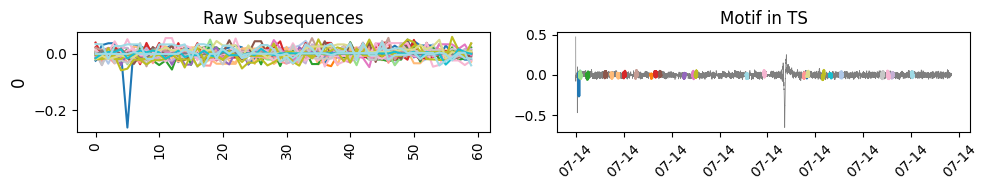

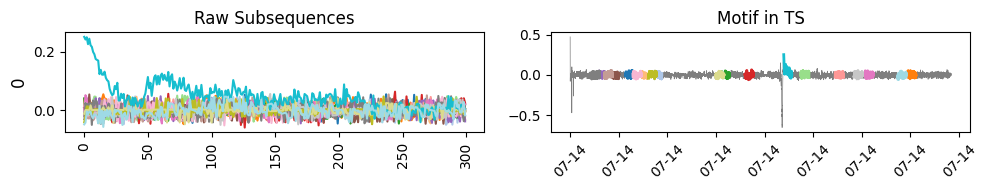

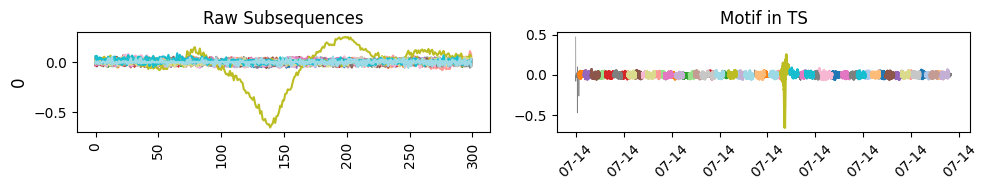

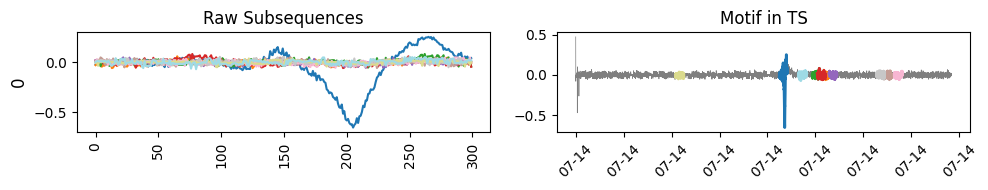

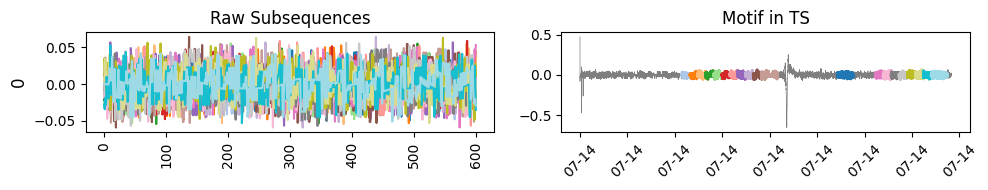

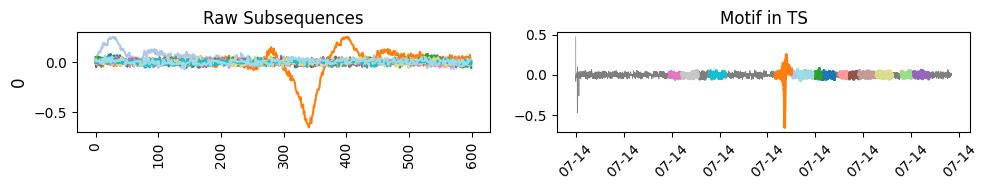

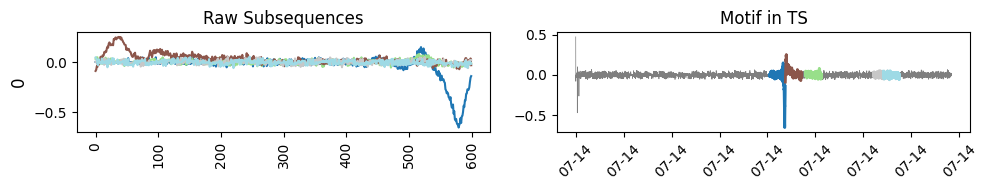

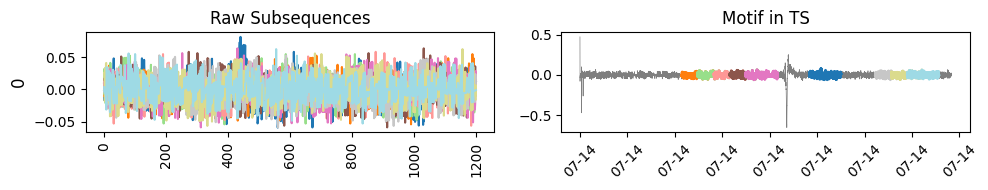

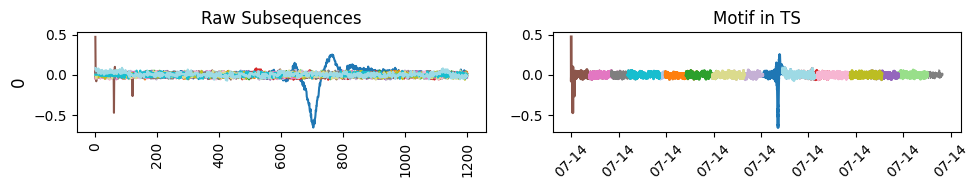

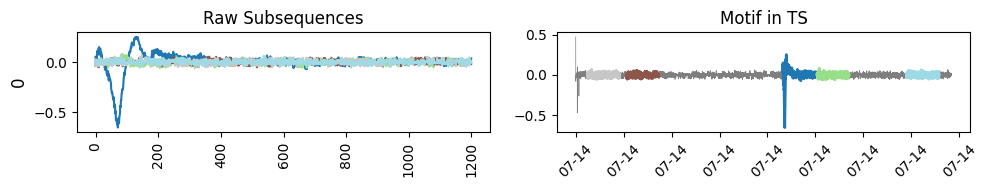

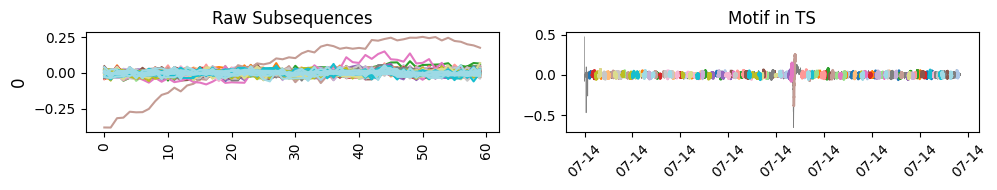

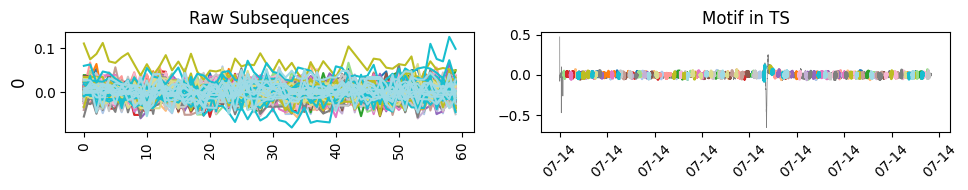

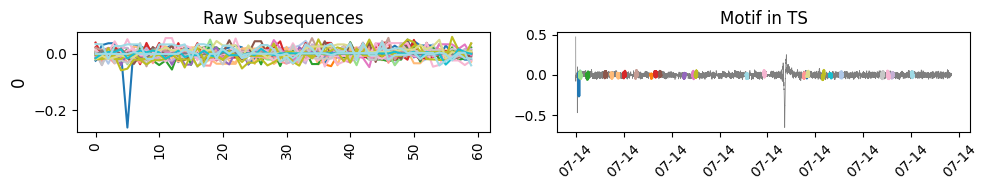

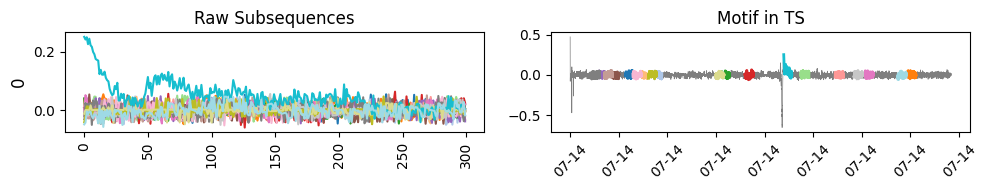

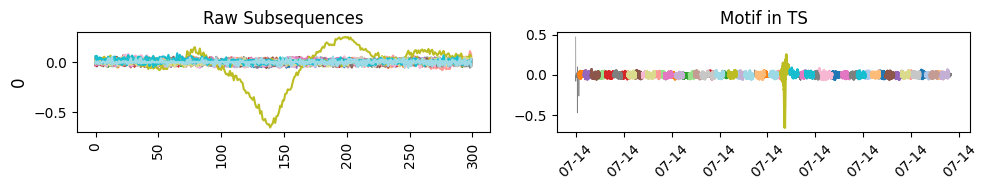

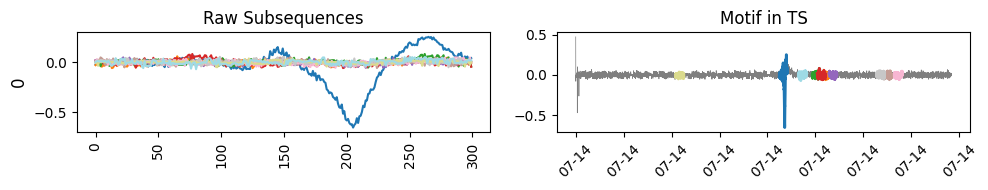

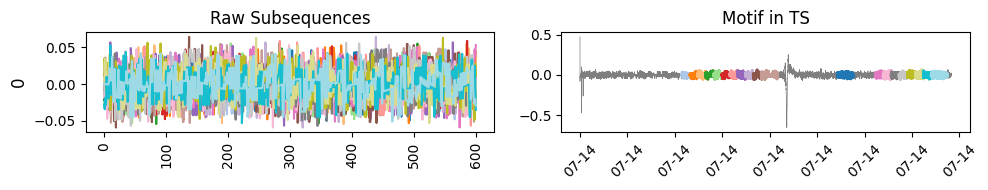

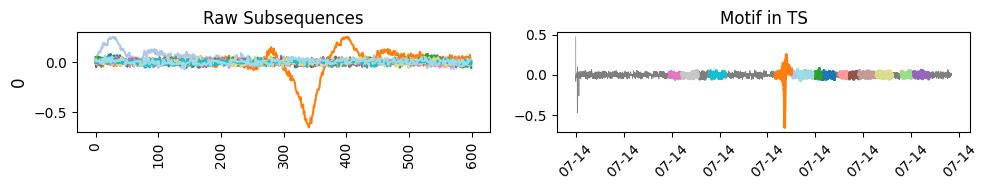

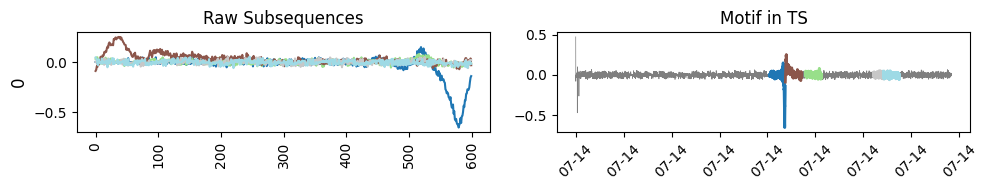

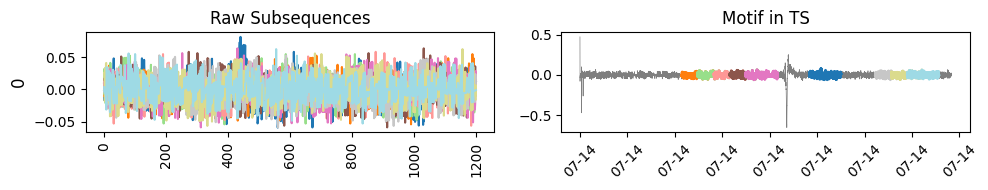

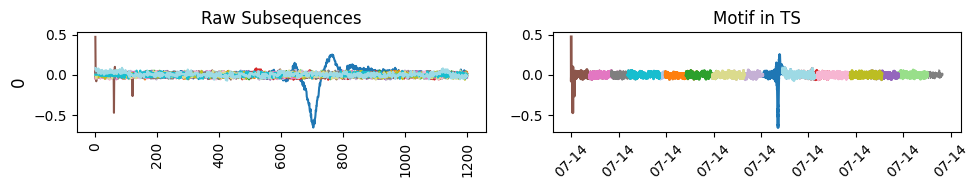

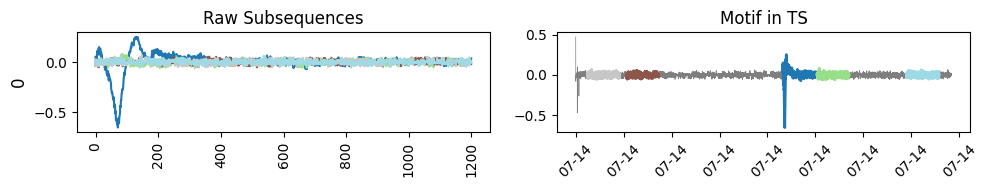

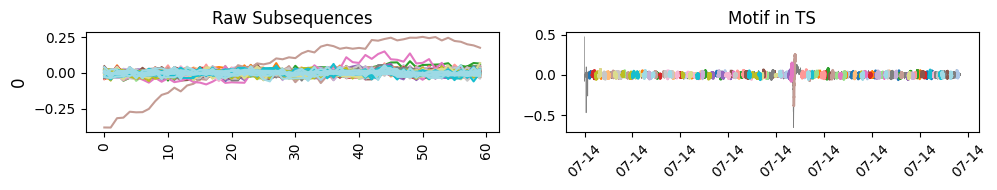

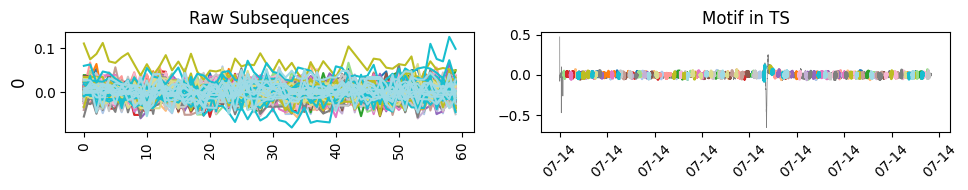

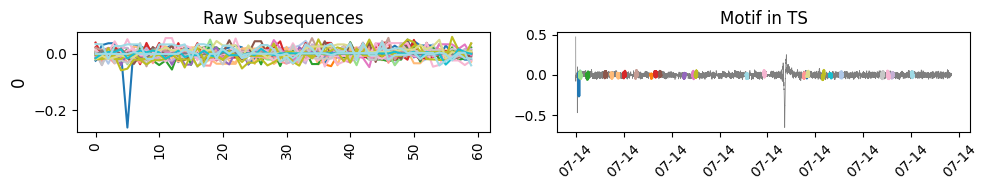

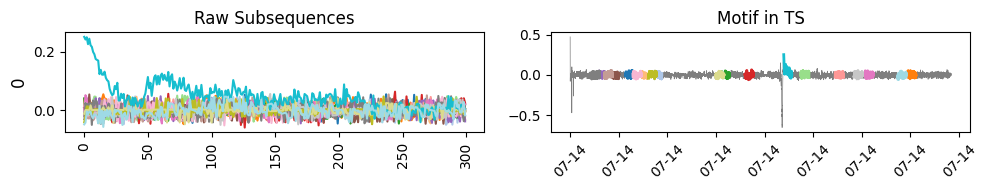

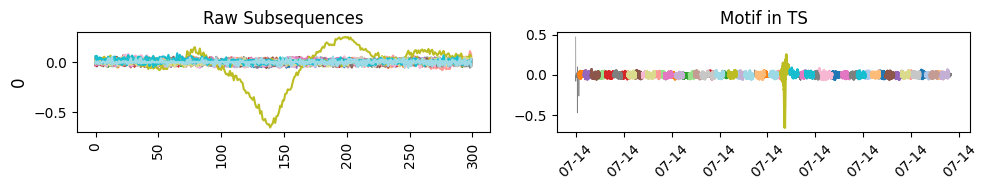

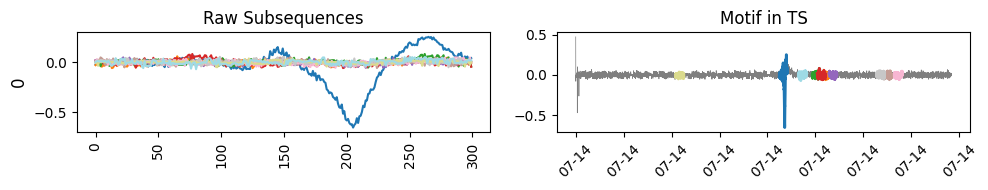

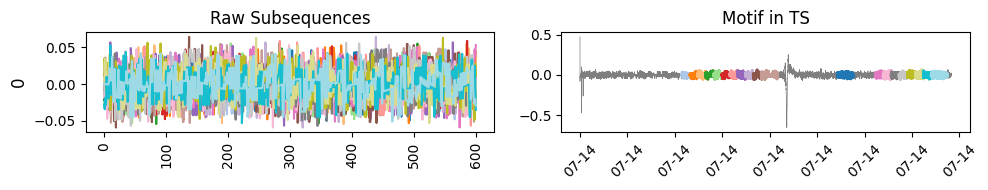

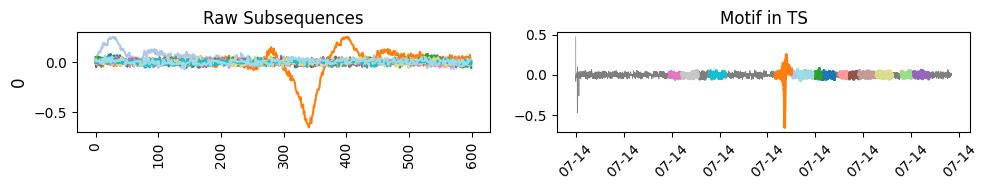

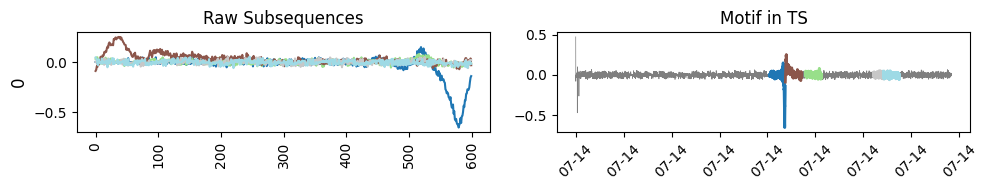

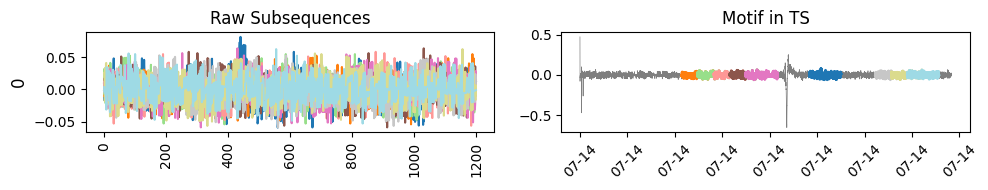

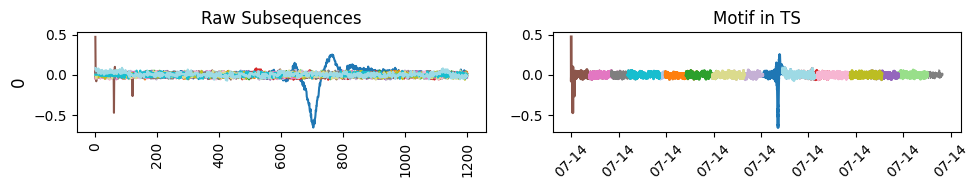

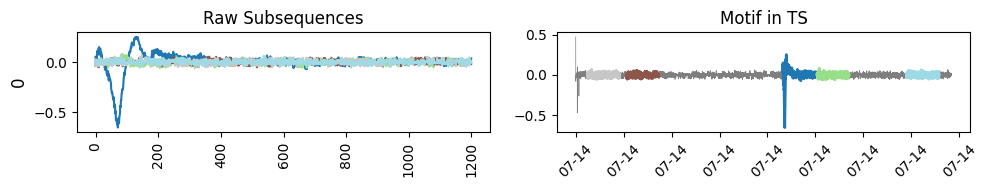

In [11]:
#plot top motif
for i, data_feature in enumerate(data.columns):
    print(data_feature)
    mp_stats_table = pd.read_csv('../results/washingmachine/table_motifs_min_neighbors={}_max_distance={}_cutoff={}_max_matches={}_max_motifs={}.csv'.format(min_neighbors, max_distance, cutoff, max_matches, max_motifs))
    subsequence_lengths = mp_stats_table["m"].unique()
    ts = pd.DataFrame(resids[feature].values, index=resids[feature].index)
    ts.index = pd.to_datetime(ts.index)
    for m in subsequence_lengths:
        print("Motif length: ", m)
        top_motifs = mp_stats_table[mp_stats_table["m"] == m]
        top_motifs = top_motifs.sort_values(by="p-value").head(3)
        for top_motif in top_motifs.to_dict(orient="records"): 
            print(top_motif)
            m = top_motif["m"]
            dimensions = [top_motif["Features"]]
            features = sorted([int(dimension) for dimension in dimensions])
            indices = top_motif['Indices'].replace("[","").replace("]","").split(",")
            indices = [int(i) for i in indices]
            motif_name = str(i)+"_"+str(top_motif["ID"])
            ts_list = [ts]
            plot_motif(ts_list, features, m, indices, motif_name)
